<a href="https://colab.research.google.com/github/theodore-thormann/DS6050_FinalProject/blob/main/DS6050_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Final Project: Designing a Neural Network to Classify Film Poster Genres
![ToyStory](https://m.media-amazon.com/images/I/71aBLaC4TzL._AC_SL1330_.jpg) 

The motivation behind using movie posters to determine movie genres with deep learning is to develop an automated and efficient method for classifying movies into different genres. Movie posters are designed to convey information about the movie and attract an audience. One important piece of information that movie posters could possibly convey would be the style or genre of the movie. If we can see if a movie’s genre can be predicted by the movie’s poster, then using a movie poster as data may be helpful in other neural network processes like recommendation algorithms.

# Load Packages

In [14]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import glob
from sklearn.preprocessing import MultiLabelBinarizer
import scipy

import torch

import pandas as pd

# Random Seed for Reproduction

In [5]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Image Dataset

In [6]:
image_paths = glob.glob("/content/drive/MyDrive/DeepLearningData/FinalProject/SampleMoviePosters/SampleMoviePosters/*.jpg")

image_ids = []

for path in image_paths:
    start = path.rfind("/")+1
    end = len(path)-4
    image_ids.append(path[start:end])

In [7]:
image_ids

['17162',
 '16129',
 '14611',
 '19422',
 '16013',
 '18937',
 '18166',
 '18037',
 '10281',
 '15039',
 '19788',
 '20686',
 '13075',
 '17567',
 '20919',
 '21042',
 '16258',
 '17813',
 '17463',
 '15167',
 '12570',
 '18311',
 '11723',
 '20479',
 '19702',
 '21197',
 '20876',
 '21153',
 '15532',
 '12499',
 '20691',
 '15881',
 '21375',
 '21110',
 '18051',
 '20852',
 '20656',
 '16914',
 '10747',
 '18770',
 '20821',
 '14538',
 '12255',
 '12364',
 '17075',
 '18526',
 '15693',
 '11358',
 '17128',
 '12486',
 '21016',
 '10307',
 '17350',
 '12278',
 '10323',
 '21156',
 '10418',
 '16691',
 '10726',
 '20122',
 '20210',
 '17621',
 '19571',
 '19109',
 '20641',
 '19074',
 '11656',
 '13501',
 '19823',
 '16939',
 '16953',
 '16895',
 '13140',
 '21074',
 '15064',
 '19699',
 '18523',
 '11909',
 '21632',
 '14429',
 '18218',
 '19412',
 '19959',
 '17534',
 '18217',
 '20446',
 '18179',
 '11904',
 '21140',
 '11521',
 '20585',
 '10821',
 '21040',
 '11652',
 '17416',
 '16039',
 '11960',
 '20793',
 '20142',
 '13055',


# Import Movie Genre CSV and Create Genre Classes

In [8]:
data = pd.read_csv('/content/drive/MyDrive/DeepLearningData/FinalProject/MovieGenre.csv', encoding = "ISO-8859-1")

In [10]:
y = []
classes = tuple()
for image_id in image_ids:
    genres = tuple((data[data["imdbId"] == int(image_id)]["Genre"].values[0]).split("|"))
    y.append(genres)
    classes = classes + genres
mlb = MultiLabelBinarizer()
mlb.fit(y)
y = mlb.transform(y)
classes = set(classes)
classes = list(classes)
classes.sort()

In [11]:
classes

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [ ]:
y_df = pd.DataFrame(y, columns = classes)
y_df

In [ ]:
import matplotlib.pyplot as plt

y_plt = y_df.sum(0).sort_values(ascending = False)

plt.xticks(rotation=90);
plt.bar(y_plt.index.tolist(),y_plt.values);

# Get images and split the train test set




In [17]:
def get_image(image_path):
    image = scipy.misc.imread(image_path)
    image = scipy.misc.imresize(image, (150, 150))
    image = image.astype(np.float32)
    return image

In [ ]:
dataset_all = ImageFolder(
    data_dir = get_image(),
    transform=ToTensor(),
)

In [13]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import transforms


TEST_RATIO = 0.15
VAL_RATIO = 0.15
BATCH_SIZE = 32

# Download and load the training data
dataset_all = ImageFolder(
    data_dir = get_image(),
    transform=ToTensor(),
)

size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = int(size_all * TEST_RATIO)
size_val = int(size_all * VAL_RATIO)
size_train = int(size_all - size_test - size_val)

dataset_train, dataset_val, dataset_test = random_split(dataset_all, [size_train, size_val, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_val)={len(dataset_val)}. len(dataset_test)={len(dataset_test)}')

# NOTE that you must not use the test dataset for model selection


FileNotFoundError: ignored

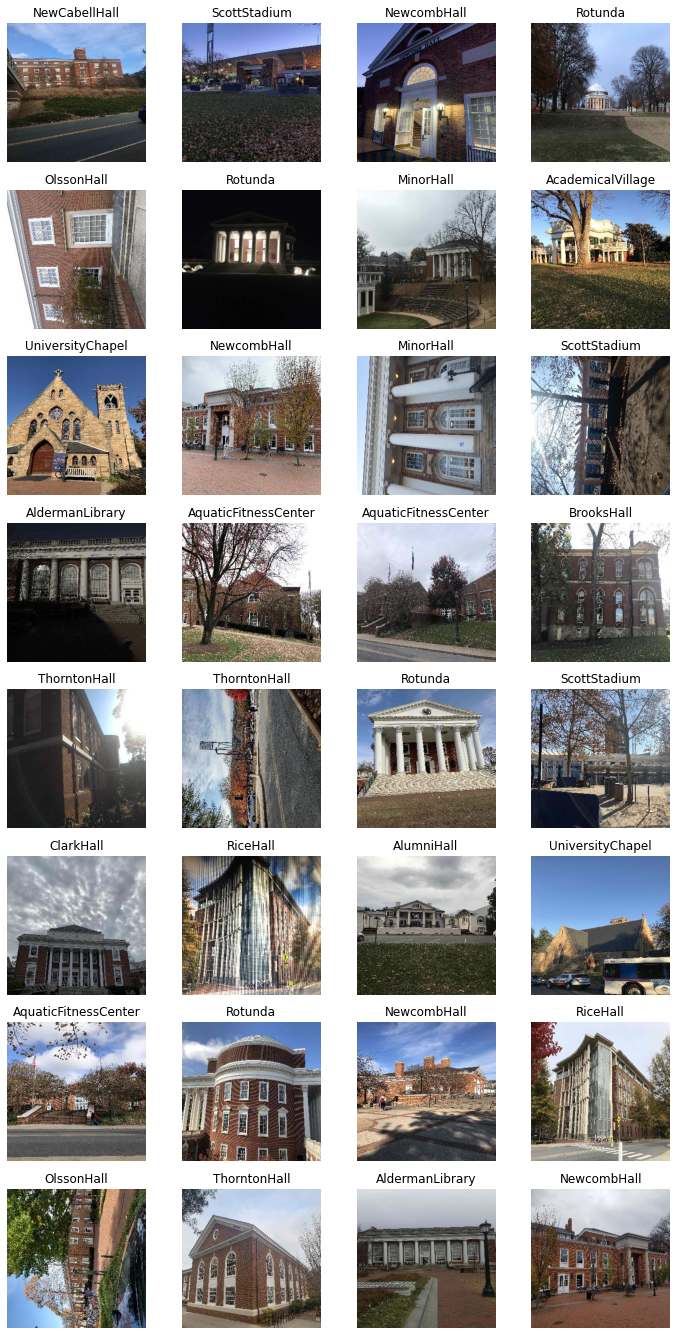

In [ ]:
from torchvision.transforms.functional import to_pil_image


# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
# 18 different classifications
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

plt.show()

# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks. 

Best of luck!

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
           
    'val' : torch.utils.data.DataLoader(dataset_val,
                                         batch_size=32,
                                         shuffle=True,
                                         num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_loop_original(dataloader, model, loss_fn, optimizer, calculating_accuracy=True):
    model.train()
    size = len(dataloader.dataset)
    losses_train = []
    steps = []
    if calculating_accuracy:
        accuracies_epoch = []
    for batch, (X, y) in enumerate(dataloader):
        # Move data from the CPU to the GPU
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss (forward pass)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation (backward pass)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        current = batch * len(X)

        loss = loss.item()
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses_train.append(loss)
        steps.append(current)
        # Compute accuracy without affecting the gradients

        if calculating_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculating_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

train_loop = train_loop_original


import torch

@torch.no_grad()
def test_loop_original(dataloader, model, loss_fn, method="Test", calculating_accuracy=True):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    if calculating_accuracy:
        correct = 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        if calculating_accuracy:
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    if not calculating_accuracy:
        print(f"{method} Avg loss: {test_loss:>8f} \n")
        return -1, test_loss
    correct /= size
    print(f"{method} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

test_loop = test_loop_original

In [ ]:
import torch
from torch import nn

def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid, dataloader_test, calculating_accuracy=True):
    accuracies_train_all_epochs = []
    steps_all_epochs = []
    accuracies_val_all_epochs = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch, steps = train_loop(dataloader_train, model, loss_function, optimizer, calculating_accuracy=calculating_accuracy)
        accuracies_train_all_epochs.append(accuracies_epoch)
        steps_all_epochs.append(steps)

        accuracy_val, loss_val = test_loop(dataloader_valid, model, loss_function, method="Valid", calculating_accuracy=calculating_accuracy)
        accuracies_val_all_epochs.append(accuracy_val)
    print("Test Error: ")
    test_loop(dataloader_test, model, loss_function, method="Valid", calculating_accuracy=calculating_accuracy)
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs

In [ ]:
import pandas as pd
from numpy import mean


def plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, method='mean'):
    if method == 'mean':
        accuracies_train = [mean(accuracies_train_per_epoch) for accuracies_train_per_epoch in accuracies_train_all_epochs]
    elif method == 'end':
        accuracies_train = [accuracies_train_per_epoch for accuracies_train_per_epoch in accuracies_train_all_epochs]

    df_runs = pd.DataFrame({
        'accuracy_train': accuracies_train,
        'accuracy_valid': accuracies_val_all_epochs,
    })

    df_runs.index += 1  # Add 1 to the index values
    df_runs.plot(figsize=(14, 10))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

# Model 1
## Model using ResNet50 architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# ResNet50 with custom input and output size
class ResBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet50(nn.Module):

    def __init__(self, num_classes=18):
        super().__init__()
        self.in_channels = 64

        # Initial conv layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks
        self.layer1 = self.make_layer(ResBlock, 64, 3, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 4, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 6, stride=2)
        self.layer4 = self.make_layer(ResBlock, 512, 3, stride=2)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

model1 = ResNet50()

In [ ]:
from torch import optim
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss() 

In [ ]:
NUM_EPOCHS = 10
model1 = model1.to(device)
accuracies_train_all_epochs1, accuracies_val_all_epochs1 = train(model1, NUM_EPOCHS, loss_fn, optimizer, loaders['train'], loaders['val'], loaders['test'])

Epoch 1
-------------------------------
loss: 3.044820  [    0/10002]
loss: 2.810599  [ 3200/10002]
loss: 2.653177  [ 6400/10002]
loss: 2.131150  [ 9600/10002]
Valid Error: 
 Accuracy: 27.6%, Avg loss: 2.647822 

Epoch 2
-------------------------------
loss: 2.367613  [    0/10002]
loss: 2.113252  [ 3200/10002]
loss: 1.664682  [ 6400/10002]
loss: 2.188309  [ 9600/10002]
Valid Error: 
 Accuracy: 23.9%, Avg loss: 2.939448 

Epoch 3
-------------------------------
loss: 1.520815  [    0/10002]
loss: 1.374195  [ 3200/10002]
loss: 1.381216  [ 6400/10002]
loss: 1.178600  [ 9600/10002]
Valid Error: 
 Accuracy: 60.3%, Avg loss: 1.416871 

Epoch 4
-------------------------------
loss: 1.245495  [    0/10002]
loss: 0.697470  [ 3200/10002]
loss: 0.838819  [ 6400/10002]
loss: 0.721028  [ 9600/10002]
Valid Error: 
 Accuracy: 64.8%, Avg loss: 1.248253 

Epoch 5
-------------------------------
loss: 0.949053  [    0/10002]
loss: 0.718118  [ 3200/10002]
loss: 0.687452  [ 6400/10002]
loss: 0.859177  [ 

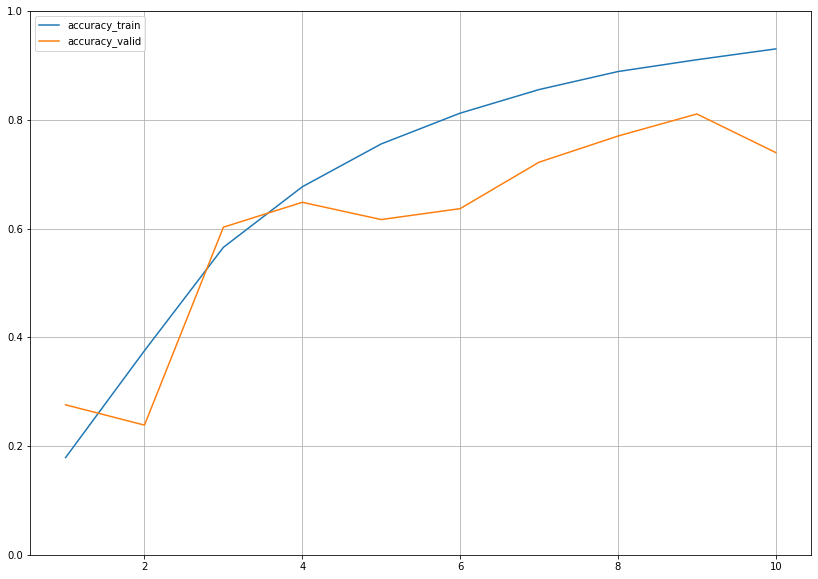

In [ ]:
plot_history(accuracies_train_all_epochs1, accuracies_val_all_epochs1)

# Model 2
## Imported DenseNet model

In [ ]:
import torchvision
import torch.nn as nn

model2 = torchvision.models.densenet201(pretrained=True)
num_ftrs = model2.classifier.in_features
model2.classifier = nn.Linear(num_ftrs, 18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
from torch import optim
optimizer = optim.Adamax(model2.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss() 

In [ ]:
NUM_EPOCHS = 5
model2 = model2.to(device)
accuracies_train_all_epochs2, accuracies_val_all_epochs2 = train(model2, NUM_EPOCHS, loss_fn, optimizer, loaders['train'], loaders['val'], loaders['test'])

Epoch 1
-------------------------------
loss: 2.946847  [    0/10002]
loss: 0.588175  [ 3200/10002]
loss: 0.581183  [ 6400/10002]
loss: 0.314385  [ 9600/10002]
Valid Error: 
 Accuracy: 81.3%, Avg loss: 0.695463 

Epoch 2
-------------------------------
loss: 0.281542  [    0/10002]
loss: 0.281140  [ 3200/10002]
loss: 0.067362  [ 6400/10002]
loss: 0.563679  [ 9600/10002]
Valid Error: 
 Accuracy: 92.3%, Avg loss: 0.304336 

Epoch 3
-------------------------------
loss: 0.084570  [    0/10002]
loss: 0.054573  [ 3200/10002]
loss: 0.020698  [ 6400/10002]
loss: 0.586212  [ 9600/10002]
Valid Error: 
 Accuracy: 94.2%, Avg loss: 0.258440 

Epoch 4
-------------------------------
loss: 0.146911  [    0/10002]
loss: 0.102581  [ 3200/10002]
loss: 0.063121  [ 6400/10002]
loss: 0.156981  [ 9600/10002]
Valid Error: 
 Accuracy: 93.6%, Avg loss: 0.262787 

Epoch 5
-------------------------------
loss: 0.061957  [    0/10002]
loss: 0.080766  [ 3200/10002]
loss: 0.097354  [ 6400/10002]
loss: 0.076108  [ 

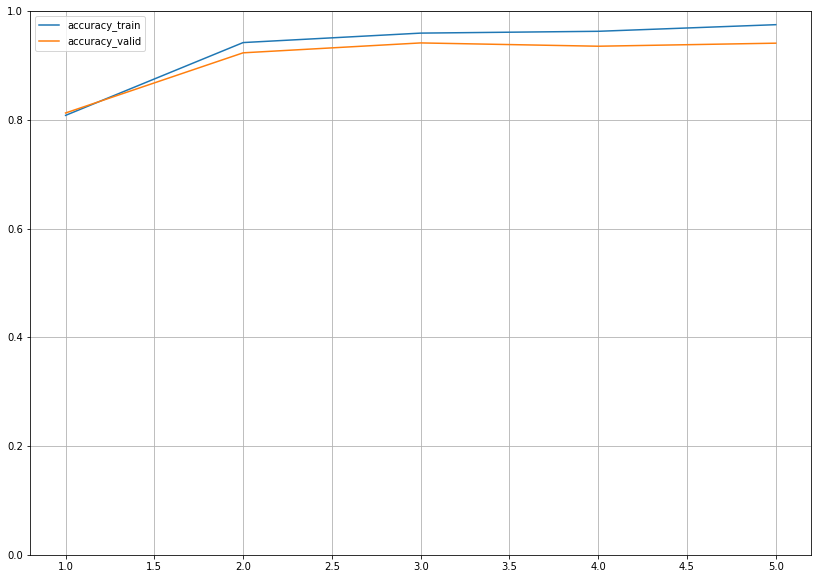

In [ ]:
plot_history(accuracies_train_all_epochs2, accuracies_val_all_epochs2)

# Model 3
## Homemade model using 2 convlution layers with ReLU activation and a maxpooling layer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Feel free to rename them!
class MyCNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(180000, 128)
        self.fc2 = nn.Linear(128, 18)



    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 180000)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model3 = MyCNN3()

In [ ]:
from torch import optim
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss() 

In [ ]:
NUM_EPOCHS = 25
model3 = model3.to(device)
accuracies_train_all_epochs3, accuracies_val_all_epochs3 = train(model3, NUM_EPOCHS, loss_fn, optimizer, loaders['train'], loaders['val'], loaders['test'])

Epoch 1
-------------------------------
loss: 2.883930  [    0/10002]
loss: 2.800126  [ 3200/10002]
loss: 2.749774  [ 6400/10002]
loss: 2.607211  [ 9600/10002]
Valid Error: 
 Accuracy: 19.9%, Avg loss: 2.573958 

Epoch 2
-------------------------------
loss: 2.534386  [    0/10002]
loss: 2.500210  [ 3200/10002]
loss: 2.294379  [ 6400/10002]
loss: 2.484767  [ 9600/10002]
Valid Error: 
 Accuracy: 30.5%, Avg loss: 2.292448 

Epoch 3
-------------------------------
loss: 2.409532  [    0/10002]
loss: 2.284396  [ 3200/10002]
loss: 2.129328  [ 6400/10002]
loss: 2.091797  [ 9600/10002]
Valid Error: 
 Accuracy: 38.0%, Avg loss: 2.115504 

Epoch 4
-------------------------------
loss: 2.046560  [    0/10002]
loss: 1.866928  [ 3200/10002]
loss: 1.525805  [ 6400/10002]
loss: 1.856017  [ 9600/10002]
Valid Error: 
 Accuracy: 42.8%, Avg loss: 1.976657 

Epoch 5
-------------------------------
loss: 1.431650  [    0/10002]
loss: 1.635502  [ 3200/10002]
loss: 1.587649  [ 6400/10002]
loss: 2.014670  [ 

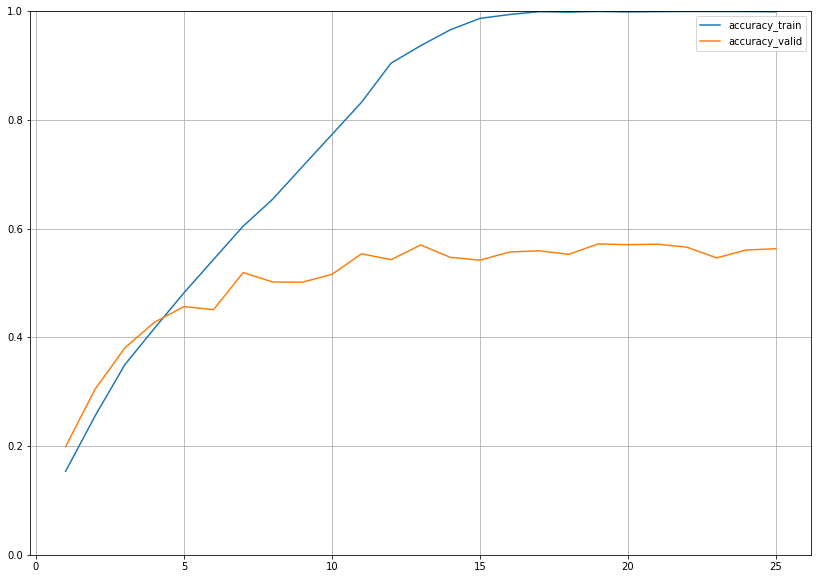

In [ ]:
plot_history(accuracies_train_all_epochs3, accuracies_val_all_epochs3)